In [ ]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path


In [16]:
images_dir = Path("data/images/train")
labels_dir = Path("data/labels/train")

all_data = []

def yolo_to_xyxy(xc, yc, bw, bh, w, h):
    x1 = (xc - bw / 2.0) * w
    y1 = (yc - bh / 2.0) * h
    x2 = (xc + bw / 2.0) * w
    y2 = (yc + bh / 2.0) * h
    # clamp to image bounds
    x1 = max(0.0, min(w, x1)); y1 = max(0.0, min(h, y1))
    x2 = max(0.0, min(w, x2)); y2 = max(0.0, min(h, y2))
    return x1, y1, x2, y2

for txt_file in labels_dir.glob("*.txt"):
    # if your images are not always .jpg, try multiple extensions:
    stem = txt_file.stem
    for ext in (".jpg", ".jpeg", ".png"):
        image_path = images_dir / f"{stem}{ext}"
        if image_path.exists():
            break
    else:
        print(f"[WARN] Image for {stem}.txt not found, skipping.")
        continue

    img = cv2.imread(str(image_path))
    if img is None:
        print(f"[WARN] Failed to read {image_path}, skipping.")
        continue
    h, w = img.shape[:2]

    with open(txt_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            # YOLO: cls xc yc bw bh  (normalized to [0,1])
            cls, xc, yc, bw, bh = map(float, parts[:5])

            # convert to pixel xyxy
            x1, y1, x2, y2 = yolo_to_xyxy(xc, yc, bw, bh, w, h)

            all_data.append({
                "image": image_path.name,
                "width": w, "height": h,
                "class_id": int(cls),

                # normalized (original) values
                "xc": xc, "yc": yc, "bw": bw, "bh": bh,

                # pixel coords
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "bbox_w": max(0.0, x2 - x1),
                "bbox_h": max(0.0, y2 - y1),
            })


In [18]:
df = pd.DataFrame(all_data)
df

,image,width,height,class_id,xc,yc,bw,bh,x1,y1,x2,y2,bbox_w,bbox_h
0,test_92.jpg,2336,4160,0,0.577701,0.549641,0.044949,0.054089,1297.009104,2174.001440,1402.009968,2399.011680,105.000864,225.010240
1,test_92.jpg,2336,4160,0,0.526971,0.544950,0.054790,0.064899,1167.009536,2132.002080,1294.998976,2401.981920,127.989440,269.979840
2,test_92.jpg,2336,4160,0,0.467892,0.544590,0.052230,0.066589,1031.991072,2126.989280,1154.000352,2403.999520,122.009280,277.010240
3,test_92.jpg,2336,4160,0,0.418878,0.541950,0.046661,0.070909,923.998960,2107.021280,1032.999056,2402.002720,109.000096,294.981440
4,test_92.jpg,2336,4160,0,0.364730,0.538701,0.057363,0.064421,785.009296,2107.000480,919.009264,2374.991840,133.999968,267.991360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158343,test_7.jpg,2448,3264,0,0.758779,0.363050,0.046160,0.120708,1800.991152,987.999744,1913.990832,1381.990656,112.999680,393.990912
158344,test_7.jpg,2448,3264,0,0.336601,0.361210,0.049020,0.130509,763.998768,965.998752,883.999728,1391.980128,120.000960,425.981376
158345,test_7.jpg,2448,3264,0,0.504700,0.567710,0.063321,0.045340,1158.000696,1779.010560,1313.010504,1927.000320,155.009808,147.989760
158346,test_7.jpg,2448,3264,0,0.629900,0.611671,0.058819,0.041970,1470.000744,1927.999104,1613.989656,2064.989184,143.988912,136.990080


In [19]:
print("Total images:", df["image"].nunique())
print("Total annotations:", len(df))
print("Categories:", df["class_id"].nunique())


Total images: 994
Total annotations: 158348
Categories: 2


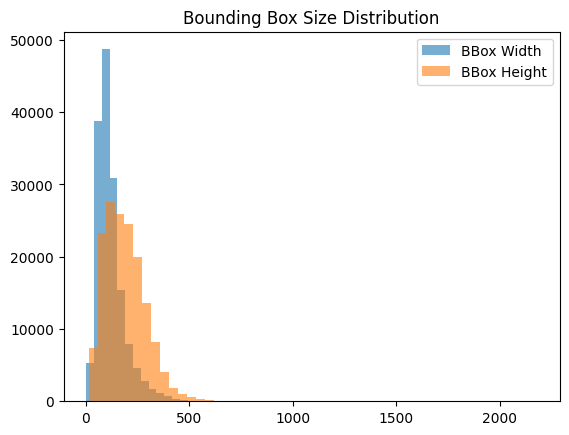

In [20]:
plt.hist(df["bbox_w"], bins=50, alpha=0.6, label="BBox Width")
plt.hist(df["bbox_h"], bins=50, alpha=0.6, label="BBox Height")
plt.legend()
plt.title("Bounding Box Size Distribution")
plt.show()


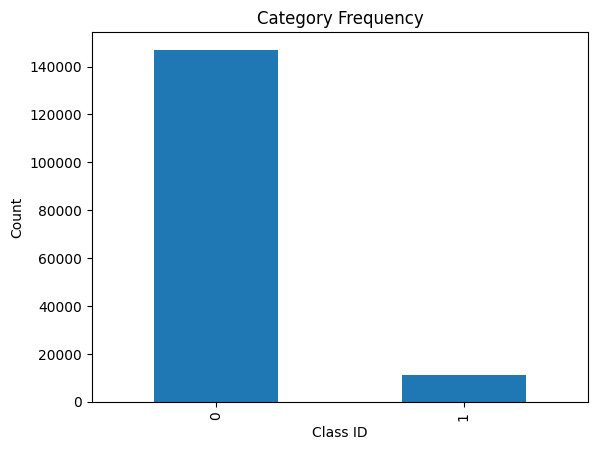

In [21]:
cat_counts = df["class_id"].value_counts()
cat_counts.plot(kind="bar")
plt.title("Category Frequency")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()
